This code is designed to retrieve surface information from input A-D image files and given instrument response parameters

In [1]:
# Generic imports
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import PIL
import copy
from scipy.interpolate import griddata
from scipy.special import gamma
import scipy.optimize as optimization
import os

# Reloading
from importlib import reload

# Local imports
import sys
sys.path.append('../../../')
import stlstuff as sls
import imagestuff as ims
import facetbrightnessstuff9 as fbs
import f90nml
import gradstuff as gds
import statstuff as sts

CUDA not available.


In [2]:
%matplotlib notebook

In [3]:
# Specify the file we want to analyze (and output file name)
pwd = os.getcwd()
print(pwd)
startpos = pwd.find('crystals/')
case = pwd[startpos+9:]; print(case)
Segmentnamelistroot = 'Segments1'
imageroot = '20190802_case1.1'
Calibrationfile = '../Case1.1/Calibration.nml'

/Users/nesh/Documents/repositories/ice2019/crystals/2019-08-02/case1.1
2019-08-02/case1.1


In [4]:
# Derivative names
Compressedfilename = Segmentnamelistroot+'_retrieved.npz'; print (Compressedfilename)
Roughnessfile = Segmentnamelistroot+'_roughness.jpg'; print(Roughnessfile)
Roughnessdatafile = Segmentnamelistroot+'_roughness.txt'; print(Roughnessdatafile)

Segments1_retrieved.npz
Segments1_roughness.jpg
Segments1_roughness.txt


In [5]:
# These are derivative names
Segmentnamelist = Segmentnamelistroot+'.nml'
Segmentfile = Segmentnamelist
SEMSegmentjpgfile =  Segmentnamelistroot+'.jpg'
Retrievedjpgfile =   Segmentnamelistroot+'_retrieved.jpg'
Compressedfilename = Segmentnamelistroot+'_retrieved'

In [6]:
# Read the input dataset, including spacing in micrometers
dx,dy,cA,cB,cC,cD,Filename = ims.getc2('', 'SEMimages/', imageroot)
print("Filename, dx and dy", Filename, dx, dy)

SEMimages/20190802_case1.1-A.bmp
SEMimages/20190802_case1.1-B.bmp
SEMimages/20190802_case1.1-C.bmp
SEMimages/20190802_case1.1-D.bmp
Filename, dx and dy SEMimages/20190802_case1.1-D.bmp 0.6614583 0.6614583


In [7]:
# Extract the desired segments
Segments=f90nml.read(Segmentfile) #reads the file at a given path
nysegments=Segments['Segments']['nysegments']
nxsegments=Segments['Segments']['nxsegments']
nacross=Segments['Segments']['nacross']
ndown=Segments['Segments']['ndown']
nxstart=Segments['Segments']['nxstart']
ny1start=Segments['Segments']['ny1start']
ny2start = ny1start+ndown 
nx1list = []; nx2list = []
ny1list = []; ny2list = []
for ix in range(nxsegments):
    nx1start = nxstart+ix*nacross; nx2start = nxstart+(ix+1)*nacross 
    for i in range(nysegments):
        nx1list.append(nx1start); nx2list.append(nx2start)
        ny1list.append(ny1start+i*ndown); ny2list.append(ny2start+i*ndown)
nsegments = nxsegments*nysegments

Correlation of random signals = 2.76057661366662
Correlation of detectors A-D for each segment


<IPython.core.display.Javascript object>


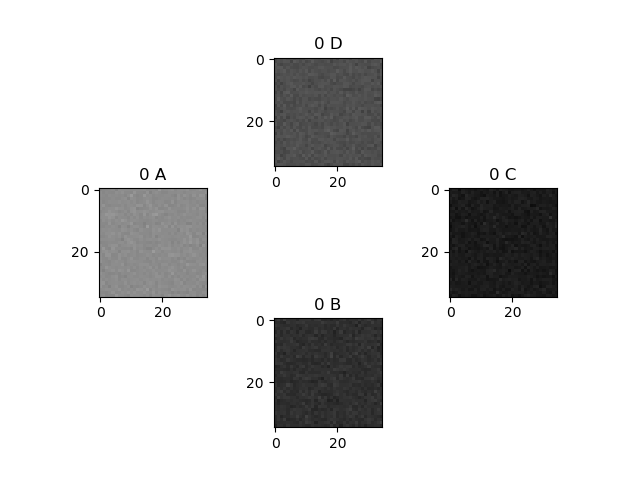

for segment  0
correlation matrix:
[[100.           3.90025148  -4.28059035  -1.56374141]
 [  0.         100.           2.84080727  -0.28929237]
 [  0.           0.         100.           2.38486932]
 [  0.           0.           0.         100.        ]]



<IPython.core.display.Javascript object>


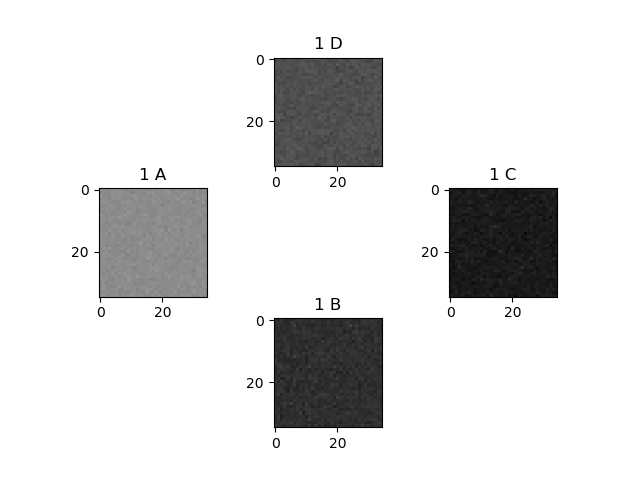

for segment  1
correlation matrix:
[[ 1.00000000e+02 -1.14120403e+00 -3.57734335e+00 -3.58372272e-01]
 [ 0.00000000e+00  1.00000000e+02  5.63001953e-02 -3.06810946e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+02  1.08223477e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+02]]



<IPython.core.display.Javascript object>


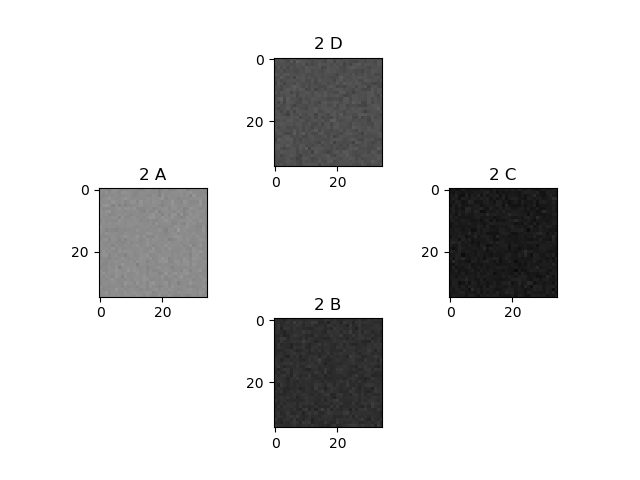

for segment  2
correlation matrix:
[[100.          -3.1045996   -0.97678755   2.30330437]
 [  0.         100.          -0.76427362  -2.92916295]
 [  0.           0.         100.           1.97790031]
 [  0.           0.           0.         100.        ]]



<IPython.core.display.Javascript object>


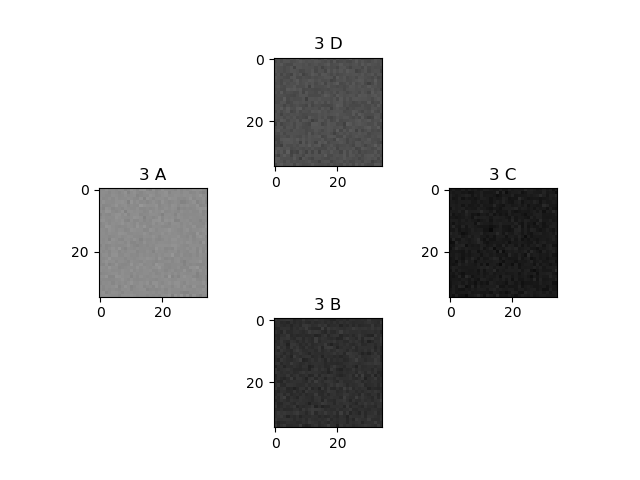

for segment  3
correlation matrix:
[[100.           1.23097998   2.78183816  -0.86500695]
 [  0.         100.           2.29267676  -8.13454858]
 [  0.           0.         100.          -5.04595017]
 [  0.           0.           0.         100.        ]]



<IPython.core.display.Javascript object>


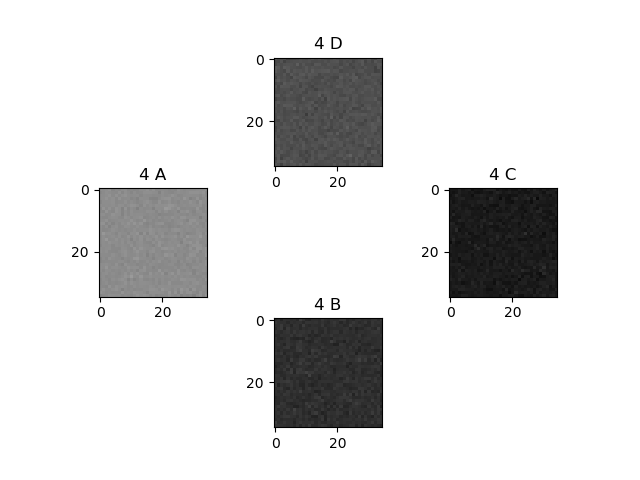

for segment  4
correlation matrix:
[[100.          -1.66437313  -1.84201839  -4.31491562]
 [  0.         100.           0.54284544   1.50909799]
 [  0.           0.         100.          -1.85175636]
 [  0.           0.           0.         100.        ]]



<IPython.core.display.Javascript object>


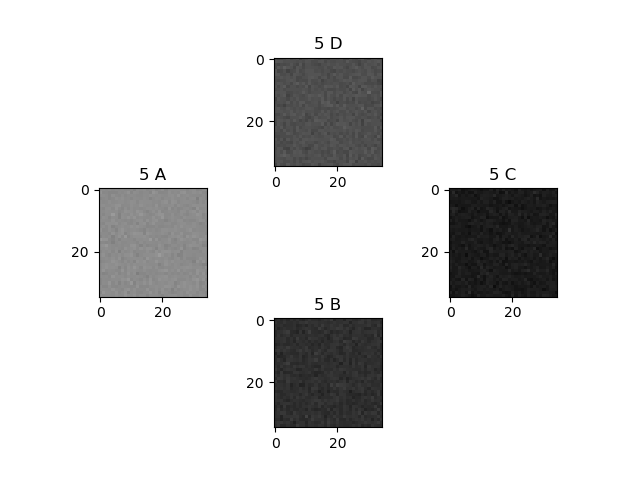

for segment  5
correlation matrix:
[[ 1.00000000e+02  2.54354373e+00  3.06620531e+00 -5.06724884e-02]
 [ 0.00000000e+00  1.00000000e+02 -2.73052129e+00  7.26165579e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+02  5.55531706e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+02]]



<IPython.core.display.Javascript object>


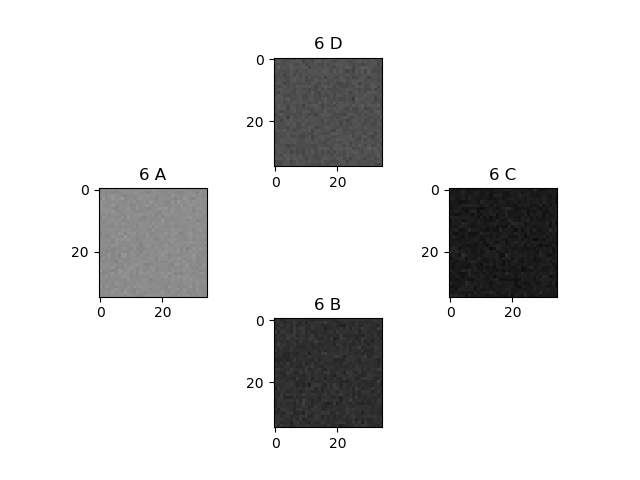

for segment  6
correlation matrix:
[[100.          -4.97818617  -1.58398744   2.39690435]
 [  0.         100.           3.39908728   0.38554563]
 [  0.           0.         100.           4.35835123]
 [  0.           0.           0.         100.        ]]



<IPython.core.display.Javascript object>


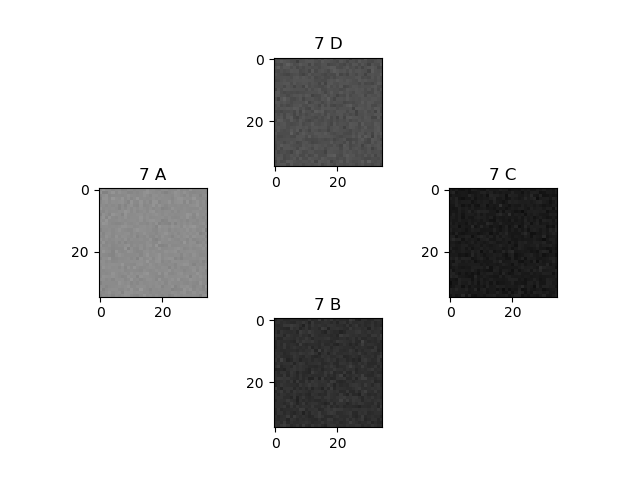

for segment  7
correlation matrix:
[[100.           1.86154353  -4.78357859  -2.92457841]
 [  0.         100.           1.27730013  -0.9755942 ]
 [  0.           0.         100.          -4.18486275]
 [  0.           0.           0.         100.        ]]



<IPython.core.display.Javascript object>


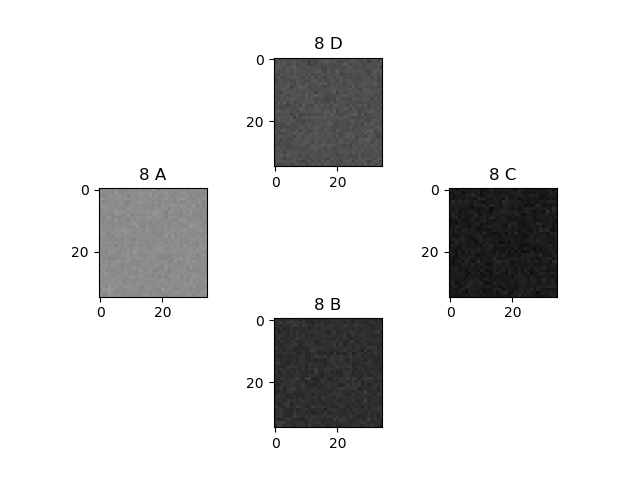

for segment  8
correlation matrix:
[[100.          -3.14260524  -1.0136758   -3.08379435]
 [  0.         100.          -0.1214874   -0.12057562]
 [  0.           0.         100.          -1.44156096]
 [  0.           0.           0.         100.        ]]



<IPython.core.display.Javascript object>


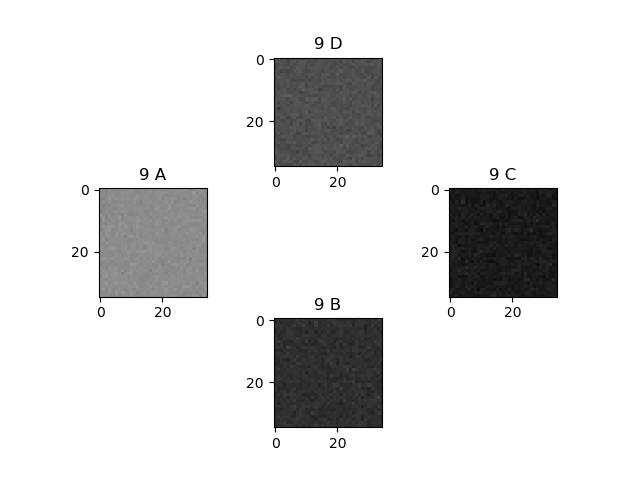

for segment  9
correlation matrix:
[[100.          -1.43000071  -1.07974523   5.45110527]
 [  0.         100.          -4.64250721  -2.53984013]
 [  0.           0.         100.           3.24933785]
 [  0.           0.           0.         100.        ]]



<IPython.core.display.Javascript object>


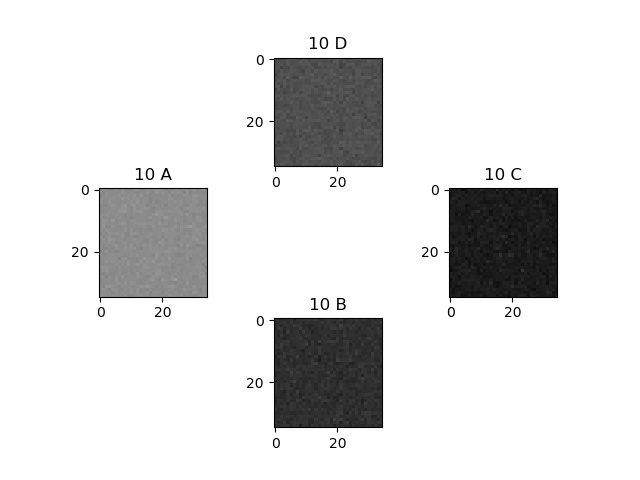

for segment  10
correlation matrix:
[[100.          -2.04327508  -1.00628295   0.91404505]
 [  0.         100.          -1.73646789   4.26025736]
 [  0.           0.         100.          -3.59907438]
 [  0.           0.           0.         100.        ]]



<IPython.core.display.Javascript object>


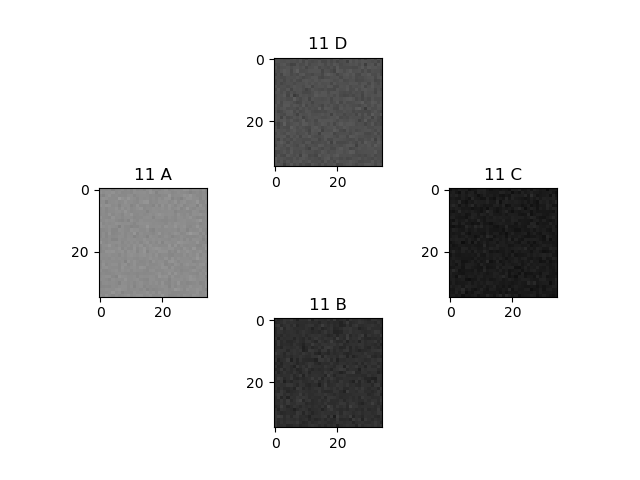

for segment  11
correlation matrix:
[[100.           2.21964225  -0.59248255   3.16062553]
 [  0.         100.          -1.48049543   4.76836945]
 [  0.           0.         100.          -2.05847287]
 [  0.           0.           0.         100.        ]]



<IPython.core.display.Javascript object>


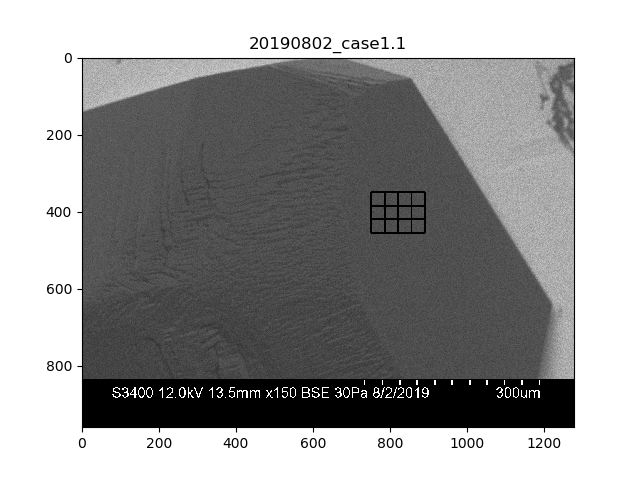

In [20]:
# Display
im = PIL.Image.open(Filename)

# Set up sub-grids in case of multiple segments
nyxgrid = []
for i in range(nsegments):
    nyxgridi = [ (y, x) for y in range(ny1list[i], ny2list[i]+1) for x in range(nx1list[i], nx2list[i]+1) ]
    nyxgrid.append(nyxgridi)

# Add the segments to the image
draw = PIL.ImageDraw.Draw(im)
for i in range(nsegments):
    nx1 = nx1list[i]
    nx2 = nx2list[i]
    ny1 = ny1list[i]
    ny2 = ny2list[i]
    ims.myrectangle(draw,(nx1,ny1),(nx2,ny2),5)

# What's the random expectation of information content
print('Correlation of random signals =', sts.randomcorrelation(nacross,ndown)*100)
    
# Loop to evaluate the information content in each segment
print('Correlation of detectors A-D for each segment')
for isegment in range(nsegments):
    
    print('for segment ', isegment)
    nx1=nx1list[isegment]; nx2=nx2list[isegment]; nx = nx2-nx1+1
    ny1=ny1list[isegment]; ny2=ny2list[isegment]; ny = ny2-ny1+1
    cAseg = cA[ny1:ny2,nx1:nx2]; #cAsegmean = np.mean(cAseg); print('<cA> =',cAsegmean)
    cBseg = cB[ny1:ny2,nx1:nx2]; #cBsegmean = np.mean(cBseg); print('<cB> =',cBsegmean)
    cCseg = cC[ny1:ny2,nx1:nx2]; #cCsegmean = np.mean(cCseg); print('<cC> =',cCsegmean)
    cDseg = cD[ny1:ny2,nx1:nx2]; #cDsegmean = np.mean(cDseg); print('<cD> =',cDsegmean)
    cseg = [cAseg,cBseg,cCseg,cDseg]
    infomatrix = sts.getinfomatrix(cseg)
    print('correlation matrix:')
    print(infomatrix*100)
    print('')

    # Show what the detectors see
    plt.figure()
    plt.subplot(334); plt.imshow(np.asarray(cAseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' A')
    plt.subplot(338); plt.imshow(np.asarray(cBseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' B')
    plt.subplot(336); plt.imshow(np.asarray(cCseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' C')
    plt.subplot(332); plt.imshow(np.asarray(cDseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' D')

# Show it
plt.figure()
plt.imshow(np.asarray(im), cmap = 'Greys_r', vmin = 0, vmax = 255)
plt.title(imageroot)

# Save a copy
im.save(SEMSegmentjpgfile)

In [9]:
# Read and unpack the calibration data

# Just echo input data files  
print(Calibrationfile)

# Extract
Calibration=f90nml.read(Calibrationfile) #reads the file at a given path
pA=Calibration['Calibration']['pA']
pB=Calibration['Calibration']['pB']
pC=Calibration['Calibration']['pC']
pD=Calibration['Calibration']['pD']

../Case1.1/Calibration.nml


In [10]:
# Set up a grid of surface normal vectors and the backscatter response on them
nptsx = 103
nptsy = 101
nxmid = int(nptsx/2); #print nxmid
nymid = int(nptsy/2); #print nymid
nmax = 5
nxi = np.linspace(-nmax,nmax,nptsx); dnx = nxi[1]-nxi[0]
nyi = np.linspace(-nmax,nmax,nptsy); dny = nyi[1]-nyi[0]
nxigrid,nyigrid = np.meshgrid(nxi,nyi)
theta = 15*np.pi/180
sA = (-nxigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sB = (-nyigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sC = (+nxigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sD = (+nyigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5

# Set up the grids     
BSgridA = np.polyval(pA,sA)
BSgridB = np.polyval(pB,sB)
BSgridC = np.polyval(pC,sC)
BSgridD = np.polyval(pD,sD)

In [11]:
# Generating the response function for each detector
BSgridN = [BSgridA, BSgridB, BSgridC, BSgridD]
BSgridL = ['A', 'B', 'C', 'D']
BSmax = 150 # this for display purposes
nxigrid.shape

(101, 103)

In [12]:
# Set up interpolators for detector responses
Arule, Brule, Crule, Drule, \
KAxrule, KAyrule, KBxrule, KByrule, KCxrule, KCyrule, KDxrule, KDyrule =\
fbs.setupdetectorresponse2(BSgridA, BSgridB, BSgridC, BSgridD, nxi, nyi, dnx, dny)

In [13]:
# Create a blank slate
solution = np.zeros(cA.shape)

In [14]:
# Generic retrieval parameters
maxiter = 4
tolerance = 10

In [15]:
# Create the a priori/solution set, and the uncertainty set
    
# Define the variance in the observations (BS units^2)
#noiseamp = 5.0
noiseamp = 12.0
print('Std deviation in input signal is', noiseamp**.5)

# Define parameters determining the variance in the a priori (microns^2)
apriorivar0 = 225.0

print('Std deviation in a priori is', apriorivar0**.5)

# Create the initial a priori variance
apriorivar = np.ones(cA.shape)*apriorivar0

# Create the initial a priori set
aprioriset = np.zeros(cA.shape)

Std deviation in input signal is 3.4641016151377544
Std deviation in a priori is 15.0


In [16]:
# Loop to retrieve each segment
for isegment in range(nsegments):
    
    # Choose the particular location of the dataset to analyze
    nx1=nx1list[isegment]; nx2=nx2list[isegment]; nx = nx2-nx1+1
    ny1=ny1list[isegment]; ny2=ny2list[isegment]; ny = ny2-ny1+1

    # Construct gradients
    Ny_unscaled, Nx_unscaled = gds.makeNxNy(ny,nx)
    Ny = Ny_unscaled/dy
    Nx = -Nx_unscaled/dx #fixing x inversion
    
    # Number of observations
    nobs = (nx-1)*(ny-1)*4

    # Number of desired points (heights)
    nzpts = ny*nx-1
    
    # Extract the a priori variance
    vartemp = apriorivar[ny1:ny2+1,nx1:nx2+1]
    vartemp_long = np.reshape(vartemp,nzpts+1,0)
    Sa = np.diag(vartemp_long[:-1]); #print "apriorivar", shape(Sa)
    
    # Extract the starting z
    settemp = solution[ny1:ny2+1,nx1:nx2+1]
    settemp_long = np.reshape(settemp,nzpts+1,0)
    settemp_longminus1 = settemp_long[:-1]
    z_start = np.matrix(settemp_longminus1).T; #print "aprioriset", shape(z_start)
    z_start = z_start*0.0; #print "aprioriset", shape(z_start)

    # Construct the variance in observation + model
    Se = np.matrix(np.eye(nobs))*noiseamp # Variance in observation + model (c)

    # Do the retrieval
    print('')
    print("Segment:", isegment, '(', isegment+1, "of", nsegments, ')')
    print("for", nx1, ny1)
    z_retrieved = fbs.retrievesegment(\
        nx1,ny1,nx2,ny2,cA,cB,cC,cD,\
        Sa,Se,z_start,maxiter,tolerance,\
        Nx,Ny,\
        Arule, Brule, Crule, Drule,\
        KAxrule, KAyrule, \
        KBxrule, KByrule, \
        KCxrule, KCyrule, \
        KDxrule, KDyrule)
    
    if isegment == 0:
        solution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)
    else:
        nextsolution = np.zeros(cA.shape)
        nextsolution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)
        overlap = []
        for i in range(isegment):
            nextoverlap = list( set(nyxgrid[i])&set(nyxgrid[isegment]) )
            overlap = overlap + nextoverlap
            Noverlap = len(overlap); 
        print("Noverlap =", Noverlap)
        diff = 0.0
        for j in range(Noverlap):
            diff += nextsolution[overlap[j]] - solution[overlap[j]]
        diffavg = diff/Noverlap
        z_retrieved -= diffavg
        solution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)


Segment: 0 ( 1 of 12 )
for 750 350
Observed intensities (detector B):
mean, max, min = 38.82367346938776 53.0 28.0
<diff>, std(diff), di2 = 0.26382462967211173 8.460372995126384 23752.137300803886
<diff>, std(diff), di2 = 0.44409648595045587 4.165897738628188 1767.6591403433638
<diff>, std(diff), di2 = 0.41938747815378963 3.6170734112631475 132.52317020659729
<diff>, std(diff), di2 = 0.41422100304693743 3.549903579238267 38.770095513747265

Segment: 1 ( 2 of 12 )
for 750 385
Observed intensities (detector B):
mean, max, min = 38.817142857142855 49.0 28.0
<diff>, std(diff), di2 = 0.3093348337537444 8.473180845210171 23872.47239035638
<diff>, std(diff), di2 = 0.5210467092359723 4.141146599915357 1854.7171316203355
<diff>, std(diff), di2 = 0.4962770089498316 3.5639345355127325 161.6646653222344
<diff>, std(diff), di2 = 0.48783102451376276 3.49313698623173 72.79264121374
Noverlap = 36

Segment: 2 ( 3 of 12 )
for 750 420
Observed intensities (detector B):
mean, max, min = 39.01469387755102

140
105


<IPython.core.display.Javascript object>


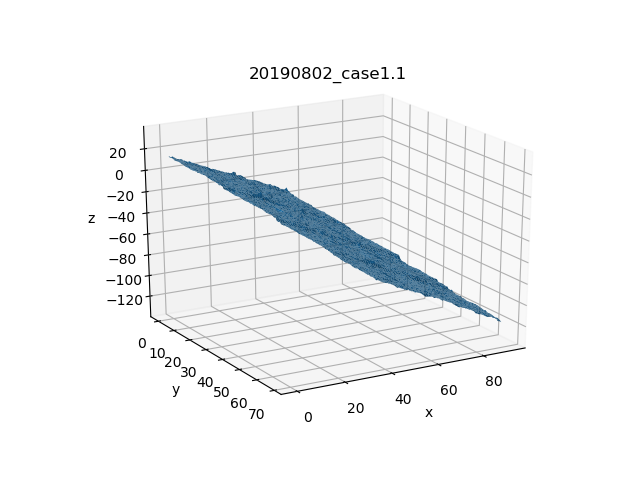

In [17]:
# Show the reconstructed surface
nx1tot = min(nx1list)
nx2tot = max(nx2list)
ny1tot = min(ny1list)
ny2tot = max(ny2list)
nxtot = nx2tot-nx1tot; print (nxtot)
nytot = ny2tot-ny1tot; print (nytot)
ymaxtot = (nytot-1)*dy; xmaxtot = (nxtot-1)*dx

surf_ytot = np.linspace(0,ymaxtot,nytot); #print surf_ytot[1]-surf_ytot[0]; 
surf_xtot = np.linspace(0,xmaxtot,nxtot); #print surf_xtot[1]-surf_xtot[0]; 
surf_xgridtot, surf_ygridtot = np.meshgrid(surf_xtot,surf_ytot)
settemp = solution[ny1tot:ny2tot,nx1tot:nx2tot]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(surf_xgridtot, surf_ygridtot, settemp, rstride=2,cstride=2)
ax.invert_yaxis() # invert y axis (this fixes the right-hand-oriented vs left-hand-oriented system)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title(imageroot)
ax.view_init(azim=-120,elev=22)

In [18]:
# Save this data

#save an image
fig.savefig(Retrievedjpgfile)


print("saving", Compressedfilename)
np.savez_compressed(Compressedfilename, \
                    surfaceroot=imageroot, \
                    imageroot=imageroot, \
                    nx1list=nx1list, \
                    nx2list=nx2list, \
                    ny1list=ny1list, \
                    ny2list=ny2list, \
                    pA=pA, \
                    pB=pB, \
                    pC=pC, \
                    pD=pD, \
                    sA=sA, \
                    sB=sB, \
                    sC=sC, \
                    sD=sD, \
                    nxi=nxi, \
                    nyi=nyi, \
                    dnx=dnx, \
                    dny=dny, \
                    solution=solution)

saving Segments1_retrieved
